In [2]:
using LinearAlgebra
using Plots
using Test
using Printf

#####################################
# Méthodes Quasi-Newton implémentée #
#####################################
function BFGS(sₖ, yₖ, Hₖ, Bₖ, ϕ)
    @test abs(dot(yₖ, sₖ)) > 10e-6*norm(yₖ)*norm(sₖ)
    ρₖ = 1/dot(yₖ, sₖ)
    Hₖ = (I-ρₖ*sₖ*transpose(yₖ))*Hₖ*(I-ρₖ*yₖ*transpose(sₖ)) + ρₖ*sₖ*transpose(sₖ)
    Bₖ += -Bₖ*sₖ*transpose(sₖ)*Bₖ/(dot(sₖ, Bₖ*sₖ)) + yₖ*transpose(yₖ)*ρₖ
    @test norm(Hₖ*yₖ - sₖ) < 10e-4
    @test norm(Bₖ*sₖ - yₖ) < 10e-4
    @test norm(Hₖ*Bₖ - I) < 10e-4
    return(Hₖ, Bₖ)
end

function DFP(sₖ, yₖ, Hₖ, Bₖ, ϕ)
    @test abs(dot(yₖ, sₖ)) > 10e-6*norm(yₖ)*norm(sₖ)
    ρₖ = 1/dot(yₖ, sₖ)
    Bₖ = (I-ρₖ*yₖ*transpose(sₖ))*Bₖ*(I-ρₖ*sₖ*transpose(yₖ)) + ρₖ*yₖ*transpose(yₖ)
    Hₖ += -Hₖ*yₖ*transpose(yₖ)*Hₖ/(dot(yₖ, Hₖ*yₖ)) + sₖ*transpose(sₖ)*ρₖ
    @test norm(Hₖ*yₖ - sₖ) < 10e-6
    @test norm(Bₖ*sₖ - yₖ) < 10e-6
    @test norm(Hₖ*Bₖ - I) < 10e-4
    return(Hₖ, Bₖ)
end

function SR1(sₖ, yₖ, Hₖ, Bₖ, ϕ)
    b = yₖ - Bₖ*sₖ
    @test abs(dot(b, sₖ)) > 10e-6*norm(b)*norm(sₖ)
    Bₖ += b*transpose(b)/(dot(b, sₖ))
    h = sₖ - Hₖ*yₖ
    @test abs(dot(h, yₖ)) > 10e-6*norm(yₖ)*norm(h)
    Hₖ += h*transpose(h)/(dot(h, yₖ))
    @test norm(Hₖ*yₖ - sₖ) < 10e-6
    @test norm(Bₖ*sₖ - yₖ) < 10e-6
    return(Hₖ, Bₖ)
end

function Broyden(sₖ, yₖ, Hₖ, Bₖ, ϕ)
    HBFGS, BBFGS = BFGS(sₖ, yₖ, Hₖ, Bₖ)
    HDFP, BDFP = DFP(sₖ, yₖ, Hₖ, Bₖ)
    Bₖ = ϕ*BDFP + (1-ϕ)*BBFGS
    Hₖ = inv(Bₖ)
    @test norm(Hₖ*yₖ - sₖ) < 10e-6
    @test norm(Bₖ*sₖ - yₖ) < 10e-6
    @test norm(Hₖ*Bₖ - I) < 10e-4
    return(Hₖ, Bₖ)
end

Broyden (generic function with 1 method)

In [10]:
# Un problème de minimisation sans contrainte est associé à une fonction, 
# son gradient et la matrice approchant la Hessienne
mutable struct problem
    fonction # Evaluation de la fonction
    gradient # Evaluation du gradient
    Hess # Evaluation de la Hessienne
end

In [9]:
function lineSearch(problem, x₀, Δ; affichage = true, maxiter = 1000, ϵ = 10e-8, update = BFGS, negCurvature = true, ϕ = 0.5)
    # initialisation
    g = problem.gradient
    k = 0
    pₖ = zeros(length(x₀))
    sₖ = zeros(length(x₀))
    yₖ = zeros(length(x₀))
    b = g(pₖ) # g(x) = Ax + b -> g(0) = b
    gₖ = g(x₀)
    Hₖ, Bₖ = I, I
    B = problem.Hess(x₀)
    NormP = []
    F = [] 
    α = []
    G = []
    if(affichage)
        @printf("%4s %9s %9s %6s %9s %9s %9s %9s %9s \n", "k", "dₖᵗBdₖ", "gₖᵗdₖ", "αₖ", "f(xₖ)", "||pₖ||", "||B-Bₖ||", "||gₖ||", "ρₖ")
    end
    while(k <= maxiter && norm(gₖ) > ϵ)
        if(k != 0)
            Hₖ, Bₖ = update(sₖ, yₖ, Hₖ, Bₖ, ϕ)
        end
        dₖ = -Hₖ*gₖ # Direction de descente
        ρₖ = 1/dot(yₖ, sₖ)
        bₖ = g(dₖ) - b
        if(abs(dot(gₖ, dₖ)) < 10e-6*norm(gₖ)*norm(dₖ) && negCurvature)
            if(dot(dₖ, bₖ) < -10e-6*norm(dₖ)*norm(bₖ))
                αₖ = 2*Δ/norm(dₖ)
            else
                dₖ = -gₖ
                bₖ = g(dₖ) - b
                if(dot(dₖ, bₖ) < -10e-6*norm(dₖ)*norm(bₖ))
                    αₖ = 2*Δ/norm(dₖ)
                else
                    αₖ = -dot(gₖ, dₖ)/dot(dₖ, bₖ)
                end
            end
        elseif(dot(dₖ, bₖ) <= 10e-6*norm(dₖ)*norm(bₖ) && negCurvature)
            αₖ = -2*Δ*sign(dot(gₖ, dₖ))/norm(dₖ)
        else
            αₖ = -dot(gₖ, dₖ)/dot(dₖ, bₖ)
        end
        push!(α, norm(αₖ))
        sₖ = αₖ*dₖ
        pₖ += sₖ
        if(affichage)
            @printf("%4d %8.1e %8.1e %8.1e %8.1e %8.1e %8.1e %8.1e %8.1e \n", k, dot(dₖ, B*dₖ), dot(gₖ, dₖ), αₖ, 
                problem.fonction(x₀ + pₖ), norm(pₖ), norm(Bₖ - B), norm(gₖ), ρₖ)
        end
        yₖ = g(x₀ + pₖ) - gₖ
        gₖ += yₖ # Mise à jour du gradient au nouveau point courant (gₖ₊₁ = yₖ₊₁ + gₖ)  
        if(norm(pₖ) >= Δ)
            # Si p traverse la région de confiance on trouve le réel τ ∈ [0, 1]
            # tel que ||s1 + s2 + ... + sk-1 + τ*sₖ|| = Δ
            pₖ += -sₖ # calcul de s1 + s2 + ... + sk-1 (on retire sₖ à pₖ)
            # Résolution de l'équation du second ordre ||pₙ + τ*sₙ||² = Δ²
            # <=> (||pₙ₋₁||² - Δ²) + 2*τ*dot(pₙ₋₁, sₙ) + τ²*||sₙ||² = 0
            a, b, c = dot(sₖ, sₖ), 2*dot(pₖ, sₖ), dot(pₖ, pₖ) - Δ^2
            δ = b^2 - 4*a*c
            τ = (-b + sqrt(δ))/(2*a)
            # Descente de gradient
            sᵩ = -gₖ/norm(gₖ)
            a, b = dot(sᵩ, sᵩ), 2*dot(pₖ, sᵩ)
            δ = b^2 - 4*a*c
            τᵩ = (-b + sqrt(δ))/(2*a)
            # Mise à jour de pₖ
            if(problem.fonction(x₀ + τᵩ*sᵩ + pₖ) < problem.fonction(x₀ + τ*sₖ + pₖ))
                @printf("%67s %8.1e \n", "Descente de gradient meilleure que BFGS qui nous donnait : f(x*) = ", 
                    problem.fonction(x₀ + τ*sₖ + pₖ))
                pₖ += τᵩ*sᵩ
            else
                pₖ += τ*sₖ
            end
            # Sauvegarde de l'évolution de la méthode pour affichage graphique
            push!(F, problem.fonction(x₀ + pₖ))
            push!(NormP, norm(pₖ))
            if(affichage)
               @printf("%35s %8s %8.1e %9s %8.1e \n", "sortie de la région de confiance : ", "f(x*) = ", 
                    problem.fonction(x₀ + pₖ), "||p*|| = ", norm(pₖ)) 
            end
            return(pₖ, NormP, k, F, α, G)
        end
        # Sauvegarde de l'évolution de la méthode pour affichage graphique
        push!(F, problem.fonction(x₀ + pₖ))
        push!(NormP, norm(pₖ))
        push!(G, norm(gₖ))
        k += 1
    end
    return(pₖ, NormP, k-1, F, α, G)
end

lineSearch (generic function with 1 method)

In [13]:
function CG(problem, x₀, Δ; maxiter = 1000, ϵ = 10e-8, affichage = true, negCurvature = true)
    A = problem.Hess(x₀)
    rₖ = problem.gradient(x₀)
    pₖ = -rₖ
    βₖ = 0
    k = 0
    xₖ = x₀
    normP = []
    F = []
    α = []
    G = []
    if(affichage)
        @printf("%4s %9s %6s %9s %9s %9s %9s \n", "k", "gₖᵗdₖ", "αₖ", "f(xₖ)", "||pₖ||", "||gₖ||", "β")
    end
    while(norm(rₖ) > ϵ && k <= maxiter)
        bₖ = A*pₖ
        if(dot(pₖ, bₖ) <= ϵ && negCurvature)
            if(dot(rₖ, pₖ) < ϵ)
                αₖ = 2*Δ/norm(pₖ) # On force à sortir de la région de confiance
            else
                αₖ = -2*Δ/norm(pₖ)
            end
        else
            αₖ = -dot(rₖ, pₖ)/dot(pₖ, bₖ)
        end
        push!(α, norm(αₖ))
        xₖ += αₖ*pₖ
        if(affichage)
            @printf("%4d %8.1e %8.1e %8.1e %8.1e %8.1e %8.1e \n", k, dot(pₖ, rₖ), αₖ, problem.fonction(xₖ), norm(xₖ - x₀), norm(rₖ), βₖ)
        end
        if(norm(xₖ) >= Δ)
            # Si p traverse la région de confiance on trouve le réel τ ∈ [0, 1]
            # tel que ||s1 + s2 + ... + sk-1 + τ*sₖ|| = Δ
            sₖ = αₖ*pₖ
            xₖ += -sₖ # calcul de s1 + s2 + ... + sk-1 (on retire sₖ à pₖ)
            # Résolution de l'équation du second ordre ||xₙ₋₁ + τ*αₖ*pₖ||² = Δ²
            # <=> (||xₙ₋₁||² - Δ²) + 2*τ*dot(xₙ₋₁, αₖ*pₖ) + τ²*||αₖ*pₖ||² = 0
            a = dot(sₖ, sₖ)
            b = 2*dot(xₖ, sₖ)
            c = dot(xₖ, xₖ) - Δ^2
            δ = b^2 - 4*a*c
            τ = (-b + sqrt(δ))/(2*a)
            # Mise à jour de pₖ
            xₖ += τ*sₖ
            k += 1
            push!(normP, norm(xₖ - x₀))
            push!(F, problem.fonction(xₖ))
            if(affichage)
               @printf("%35s %8s %8.1e %9s %8.1e \n", "sortie de la région de confiance : ", "f(x*) = ", 
                    problem.fonction(xₖ), "||p*|| = ", norm(xₖ - x₀)) 
            end
            return(xₖ - x₀, k, normP, F, α, G)
        end
        rₖ = problem.gradient(xₖ)
        βₖ = dot(rₖ, bₖ)/dot(pₖ, bₖ)
        pₖ = -rₖ + βₖ*pₖ
        k += 1
        push!(F, problem.fonction(xₖ))
        push!(normP, norm(xₖ - x₀))
        push!(G, norm(rₖ))
    end
    return(xₖ - x₀, k-1, normP, F, α, G)
end

CG (generic function with 1 method)

In [17]:
using LinearOperators

function LMlineSearch(problem, x₀, Δ; r = 5, affichage = true, maxiter = 1000, ϵ = 10e-8, update = BFGS, negCurvature = true, ϕ = 0.5)
    # initialisation
    g = problem.gradient
    k = 0
    n = length(x₀)
    pₖ = zeros(n)
    yₖ = zeros(n)
    sₖ = zeros(n)
    B = problem.Hess(x₀)
    S = []
    Y = []
    b = g(pₖ) # g(x) = Ax + b -> g(0) = b
    gₖ = g(x₀)
    sᵩ = zeros(length(x₀))
    τᵩ = 0
    Hₖ = InverseLBFGSOperator(n, r, scaling = false)
    NormP = []
    F = []
    α = []
    G = []
    if(affichage)
        @printf("%4s %9s %9s %6s %9s %9s %9s %9s \n", "k", "dₖᵗBdₖ", "gₖᵗdₖ", "αₖ", "f(xₖ)", "||pₖ||", "||gₖ||", "ρₖ")
    end
    while(k <= maxiter && norm(gₖ) > ϵ)
        dₖ = -Hₖ*gₖ # Direction de descente
        bₖ = g(dₖ) - b
        if(dot(dₖ, bₖ) <= 10e-6*norm(dₖ)*norm(bₖ) && negCurvature)
            αₖ = -2*Δ*sign(dot(gₖ, dₖ))/norm(dₖ)
        else
            αₖ = -dot(gₖ, dₖ)/dot(dₖ, bₖ)
        end
        push!(α, norm(αₖ))
        sₖ = αₖ*dₖ
        pₖ += sₖ
        ρₖ = 1/dot(sₖ, yₖ)
        if(affichage)
            @printf("%4d %8.1e %8.1e %8.1e %8.1e %8.1e %8.1e %8.1e \n", k, dot(dₖ, B*dₖ), dot(gₖ, dₖ), αₖ, 
                problem.fonction(x₀ + pₖ), norm(pₖ), norm(gₖ), ρₖ)
        end
        yₖ = g(x₀ + pₖ) - gₖ
        # Mise à jour de la liste des yₖ et sₖ
        push!(Hₖ, sₖ, yₖ)
        gₖ += yₖ # Mise à jour du gradient au nouveau point courant (gₖ₊₁ = yₖ₊₁ + gₖ) 
        if(norm(pₖ) >= Δ)
            # Si p traverse la région de confiance on trouve le réel τ ∈ [0, 1]
            # tel que ||s1 + s2 + ... + sk-1 + τ*sₖ|| = Δ
            pₖ += -sₖ # calcul de s1 + s2 + ... + sk-1 (on retire sₖ à pₖ)
            # Résolution de l'équation du second ordre ||pₙ + τ*sₙ||² = Δ²
            # <=> (||pₙ₋₁||² - Δ²) + 2*τ*dot(pₙ₋₁, sₙ) + τ²*||sₙ||² = 0
            a, b, c = dot(sₖ, sₖ), 2*dot(pₖ, sₖ), dot(pₖ, pₖ) - Δ^2
            δ = b^2 - 4*a*c
            τ = (-b + sqrt(δ))/(2*a)
            # Descente de gradient
            sᵩ = -gₖ/norm(gₖ)
            a, b = dot(sᵩ, sᵩ), 2*dot(pₖ, sᵩ)
            δ = b^2 - 4*a*c
            τᵩ = (-b + sqrt(δ))/(2*a)
            # Mise à jour de pₖ
            if(problem.fonction(x₀ + τᵩ*sᵩ + pₖ) < problem.fonction(x₀ + τ*sₖ + pₖ))
                @printf("%67s %8.1e \n", "Descente de gradient meilleure que BFGS qui nous donnait : f(x*) = ", 
                    problem.fonction(x₀ + τ*sₖ + pₖ))
                pₖ += τᵩ*sᵩ
            else
                pₖ += τ*sₖ
            end
            # Sauvegarde de l'évolution de la méthode pour affichage graphique
            push!(F, problem.fonction(x₀ + pₖ))
            push!(NormP, norm(pₖ))
            if(affichage)
               @printf("%35s %8s %8.1e %9s %8.1e \n", "sortie de la région de confiance : ", "f(x*) = ", 
                    problem.fonction(x₀ + pₖ), "||p*|| = ", norm(pₖ)) 
            end
            return(pₖ, NormP, k, F, α, G)
        end
        # Sauvegarde de l'évolution de la méthode pour affichage graphique
        push!(F, problem.fonction(x₀ + pₖ))
        push!(NormP, norm(pₖ))
        push!(G, norm(gₖ))
        k += 1
    end
    return(pₖ, NormP, k-1, F, α, G)
end

LMlineSearch (generic function with 1 method)

In [7]:
N = 6
# d = [1, 2, 3, 4, 3, 6] # Exemple normal (cas particulier, 1 déjà présent dans la matrice de départ)
# d = [3, 4, 10, 3, 2, 10]
# d = [3, 10, 7, 2, 5, 9]
# d = [1, 1, 1, 1, 1, 1]
# d = [10e-8, 8e-8, 4e-8, 3e-8, 2e-8, 1e-8] # matrice quasi-singulière et petit conditionnement (décrochage de SR1)
# d = [10e-5, 8, 4e3, 3e5, 2e2, 10e-2] # matrice avec gros conditionnement
# d = [10e-4, 8e3, 40e-5, 3e4, 2e-4, 10e-2] # matrice quasi-singulière avec gros contionemment (1) (décallage de CG)
# d = [10e-4, 8e3, 40, 3000, 2e-8, 10e-2] # matrice quasi-singulière avec gros contionemment (2) (décrochage de BFGS)
# d = [0.015, 3.5, -0.15, -0.25, 0.95, 111.5] # Exemple où la norme de p n'est pas croissante
# d = [0.015, 3.5, 15, 25, 0.0095, -111.5] # Exemple où l'erreur de ||Bₖ - B|| pour BFGS augmente avec SR1
# d = [-0.015, 3.5, -15, 25, -0.0095, 111.5] # Exemple où BFGS meilleur que SR1
# d = [-0.015, 3.5, 15, 25, -0.0095, 111.5] # Exemple où SR1 produit une direction ascendante à la fin (avec negCurvature = false)
# d = [3000, -4000, -3000, -0.250, 0.25, 4000] # Yoyo
N, d = 6, [-1, 0.9, -0.8, 0.15, 3.1, 3] # SR1 : alpha > 0 alors que courbure négative
# N, d = 15, [10, 9, 8, 0.35, 3.5, 3, 2, 1, 13, 20, 4.4, 7, 2.9, 0.1, 1.2]

# Construction d'une matrice symétrique de la forme QᵗDQ
D = Diagonal(d)  
A = rand(N, N)
Q, R = qr(A) #
A = transpose(Q)*D*Q
b = rand(N)

g(x) = A*x + b
f(x) = 0.5*dot(x, A*x) + dot(b, x)
B(x) = A
x₀ = zeros(N)
quadratic = problem(f, g, B)
norm(inv(A))*norm(A)

31.96229016451349

In [8]:
N = 100
A = rand(-30:0.1:30, N, N)
A = A'*A
b = rand(-30:0.1:30, N)
g(x) = A*x + b
f(x) = 0.5*dot(x, A*x) + dot(b, x)
B(x) = A
# x₀ = -A\b - 10e-4*ones(N)
x₀ = zeros(N)
println(real.(eigvals(A)))
println("A⁻¹b - x₀ = ", -A\b)

[0.00732491, 16.8497, 39.5938, 92.2969, 129.569, 172.803, 262.572, 298.405, 449.178, 652.264, 808.74, 911.899, 1082.21, 1465.91, 1608.26, 1833.13, 2108.51, 2490.27, 2907.3, 3141.93, 3580.84, 3680.99, 3878.8, 4189.71, 4540.01, 5192.53, 5772.39, 6268.86, 6430.82, 6893.87, 7726.69, 8066.44, 8470.84, 8736.9, 9070.71, 9822.88, 10618.1, 11085.0, 11347.8, 11977.3, 12739.0, 13291.4, 13783.0, 14590.2, 15182.9, 17064.3, 17586.5, 17896.2, 18597.1, 19531.1, 19945.9, 20567.8, 21168.8, 21547.9, 22967.6, 23437.1, 25843.0, 26813.3, 27861.8, 28205.4, 29825.3, 31250.2, 31621.5, 32954.5, 34057.3, 34869.2, 37600.6, 39641.6, 40307.9, 40788.4, 42666.1, 43373.0, 43672.6, 46159.0, 47190.1, 48466.1, 48792.7, 51024.6, 53274.8, 54664.6, 58788.8, 59472.0, 61480.6, 63957.5, 65013.0, 65865.1, 68306.8, 68496.7, 70903.0, 73885.2, 75976.2, 78459.0, 82915.5, 84491.1, 91484.2, 93408.6, 94403.2, 1.00037e5, 1.05536e5, 1.08271e5]
A⁻¹b - x₀ = [285.722, -333.988, -42.0937, -246.91, 190.678, 122.8, -88.4198, 168.678, -202.533

In [18]:
nC = false
Δ = Inf
println("Méthode L-BFGS")
p, NormP, iter, F, α, G = LMlineSearch(quadratic, x₀, Δ, r = 70, maxiter = 2*N, ϵ = 10e-6, update = BFGS, negCurvature = nC);

println("Méthode L-BFGS")
p₁, NormP₁, iter₁, F₁, α₁, G₁ = LMlineSearch(quadratic, x₀, Δ, r = 1, maxiter = 2*N, ϵ = 10e-6, update = BFGS, negCurvature = nC);

println("Méthode L-BFGS")
p₆, NormP₆, iter₆, F₆, α₆, G₆ = LMlineSearch(quadratic, x₀, Δ, r = 80, maxiter = 2*N, ϵ = 10e-6, update = BFGS, negCurvature = nC);

println("Méthode L-BFGS")
p₃, NormP₃, iter₃, F₃, α₃, G₃ = LMlineSearch(quadratic, x₀, Δ, r = 60, maxiter = 2*N, ϵ = 10e-6, update = BFGS, negCurvature = nC);

println("Méthode L-BFGS")
p₄, NormP₄, iter₄, F₄, α₄, G₄ = LMlineSearch(quadratic, x₀, Δ, r = 30, maxiter = 2*N, ϵ = 10e-6, update = BFGS, negCurvature = nC);

println("Méthode L-BFGS")
p₅, NormP₅, iter₅, F₅, α₅, G₅ = LMlineSearch(quadratic, x₀, Δ, r = 90, maxiter = 2*N, ϵ = 10e-6, update = BFGS, negCurvature = nC);

println("Méthode L-BFGS")
p₇, NormP₇, iter₇, F₇, α₇, G₇ = LMlineSearch(quadratic, x₀, Δ, r = 95, maxiter = 2*N, ϵ = 10e-6, update = BFGS, negCurvature = nC);

println("Méthode BFGS")
p₂, NormP₂, iter₂, F₂, α₂, G₂ = lineSearch(quadratic, x₀, Δ, maxiter = 2*N, ϵ = 10e-6, update = BFGS, negCurvature = nC); 

println("")
println("Méthode du GC")
pᵧ, iterᵧ, NormPᵧ, Fᵧ, αᵧ, Gᵧ = CG(quadratic, x₀, Δ, maxiter = 2*N, ϵ = 10e-6, negCurvature = nC)

@printf("%22s %8.1e \n","(L-BFGS r = 70) ||g(x₀ + p)|| = ", norm(g(x₀ + p)))
@printf("%22s %8.1e \n","(L-BFGS r = 1)  ||g(x₀ + p)|| = ", norm(g(x₀ + p₁)))
@printf("%22s %8.1e \n","(BFGS)          ||g(x₀ + p)|| = ", norm(g(x₀ + p₂)))
@printf("%22s %8.1e \n","(L-BFGS r = 50) ||g(x₀ + p)|| = ", norm(g(x₀ + p₃)))
@printf("%22s %8.1e \n","(L-BFGS r = 30) ||g(x₀ + p)|| = ", norm(g(x₀ + p₄)))
@printf("%22s %8.1e \n","(L-BFGS r = 90) ||g(x₀ + p)|| = ", norm(g(x₀ + p₅)))
@printf("%22s %8.1e \n","(L-BFGS r = 80) ||g(x₀ + p)|| = ", norm(g(x₀ + p₆)))
@printf("%22s %8.1e \n","(CG)            ||g(x₀ + p)|| = ", norm(g(x₀ + pᵧ)))

Méthode L-BFGS
   k    dₖᵗBdₖ     gₖᵗdₖ     αₖ     f(xₖ)    ||pₖ||    ||gₖ||        ρₖ 
   0  7.2e+08 -2.8e+04  3.9e-05 -5.4e-01  6.5e-03  1.7e+02      Inf 
   1  9.4e+08 -3.2e+04  3.4e-05 -1.1e+00  1.4e-02  1.8e+02  4.8e+16 
   2  1.0e+09 -3.6e+04  3.5e-05 -1.7e+00  2.5e-02  1.9e+02  2.9e+17 
   3  8.2e+08 -3.2e+04  3.9e-05 -2.4e+00  3.8e-02  1.8e+02  6.9e+15 
   4  1.1e+09 -4.0e+04  3.7e-05 -3.1e+00  5.4e-02  2.0e+02  4.5e+15 
   5  9.9e+08 -4.3e+04  4.3e-05 -4.0e+00  7.6e-02  2.1e+02 -6.6e+15 
   6  1.0e+09 -4.8e+04  4.8e-05 -5.2e+00  1.1e-01  2.2e+02  2.8e+15 
   7  1.7e+09 -6.6e+04  3.9e-05 -6.5e+00  1.4e-01  2.6e+02  2.6e+16 
   8  2.0e+09 -7.2e+04  3.6e-05 -7.7e+00  1.8e-01  2.7e+02 -2.5e+15 
   9  1.9e+09 -6.2e+04  3.3e-05 -8.8e+00  2.1e-01  2.5e+02 -7.2e+16 
  10  1.6e+09 -5.9e+04  3.7e-05 -9.9e+00  2.4e-01  2.4e+02 -2.1e+15 
  11  1.1e+09 -4.4e+04  3.9e-05 -1.1e+01  2.6e-01  2.1e+02 -3.6e+16 
  12  1.7e+09 -4.4e+04  2.6e-05 -1.1e+01  2.8e-01  2.1e+02 -1.3e+16 
  13  7.2e+08 -

 119  2.4e+10 -2.3e+06  9.4e-05 -4.5e+02  4.8e+01  1.5e+03  2.1e+12 
 120  2.9e+10 -1.5e+06  5.1e-05 -4.9e+02  5.2e+01  1.2e+03 -5.4e+12 
 121  1.0e+10 -2.3e+06  2.3e-04 -7.4e+02  8.3e+01  1.5e+03  8.8e+11 
 122  3.0e+11 -1.9e+07  6.2e-05 -1.3e+03  1.5e+02  4.3e+03 -1.0e+11 
 123  3.0e+11 -6.9e+06  2.3e-05 -1.4e+03  1.6e+02  2.6e+03      Inf 
 124  8.9e+09 -5.5e+05  6.1e-05 -1.4e+03  1.6e+02  7.4e+02 -9.7e+12 
 125  3.5e+09 -1.2e+06  3.3e-04 -1.6e+03  1.9e+02  1.1e+03 -8.8e+12 
 126  4.3e+10 -1.8e+07  4.1e-04 -5.3e+03  6.2e+02  4.2e+03  3.4e+10 
 127  2.7e+12 -2.7e+08  9.9e-05 -1.8e+04  2.2e+03  1.6e+04 -5.7e+09 
 128  6.3e+12 -1.3e+08  2.0e-05 -2.0e+04  2.3e+03  1.1e+04  1.4e+10 
 129  8.6e+10 -2.3e+06  2.7e-05 -2.0e+04  2.3e+03  1.5e+03 -2.9e+12 
 130  1.5e+09 -4.2e+04  2.8e-05 -2.0e+04  2.3e+03  2.0e+02 -1.4e+13 
 131  3.1e+07 -8.1e+02  2.6e-05 -2.0e+04  2.3e+03  2.8e+01  1.4e+15 
 132  9.8e+05 -2.9e+01  3.0e-05 -2.0e+04  2.3e+03  5.4e+00 -2.0e+16 
 133  1.3e+04 -3.9e-01  2.9e-05 -2

  45  9.8e+08 -3.8e+04  3.9e-05 -3.2e+01  1.3e+00  2.0e+02 -5.2e+15 
  46  5.0e+08 -2.5e+04  5.1e-05 -3.2e+01  1.3e+00  1.6e+02 -3.2e+16 
  47  4.4e+08 -2.7e+04  6.2e-05 -3.3e+01  1.4e+00  1.6e+02 -3.4e+15 
  48  3.9e+08 -2.4e+04  6.1e-05 -3.4e+01  1.4e+00  1.5e+02  3.8e+15 
  49  4.6e+08 -2.3e+04  4.9e-05 -3.4e+01  1.5e+00  1.5e+02  3.4e+15 
  50  6.0e+08 -2.4e+04  4.1e-05 -3.5e+01  1.5e+00  1.6e+02  2.3e+15 
  51  1.2e+09 -3.2e+04  2.7e-05 -3.5e+01  1.5e+00  1.8e+02 -5.1e+15 
  52  4.5e+08 -2.6e+04  5.9e-05 -3.6e+01  1.6e+00  1.6e+02 -2.9e+15 
  53  4.2e+08 -2.2e+04  5.4e-05 -3.7e+01  1.6e+00  1.5e+02 -3.3e+15 
  54  5.6e+08 -2.3e+04  4.1e-05 -3.7e+01  1.7e+00  1.5e+02  1.9e+16 
  55  7.8e+08 -2.4e+04  3.1e-05 -3.7e+01  1.7e+00  1.5e+02  2.9e+16 
  56  5.6e+08 -2.6e+04  4.6e-05 -3.8e+01  1.7e+00  1.6e+02  3.3e+15 
  57  1.7e+08 -2.1e+04  1.2e-04 -3.9e+01  1.8e+00  1.4e+02 -9.5e+14 
  58  4.1e+08 -3.0e+04  7.2e-05 -4.0e+01  1.9e+00  1.7e+02  1.2e+16 
  59  4.8e+08 -3.0e+04  6.2e-05 -4

   2  1.0e+09 -3.6e+04  3.5e-05 -1.7e+00  2.5e-02  1.9e+02  2.9e+17 
   3  8.2e+08 -3.2e+04  3.9e-05 -2.4e+00  3.8e-02  1.8e+02  6.9e+15 
   4  1.1e+09 -4.0e+04  3.7e-05 -3.1e+00  5.4e-02  2.0e+02  4.5e+15 
   5  9.9e+08 -4.3e+04  4.3e-05 -4.0e+00  7.6e-02  2.1e+02 -6.6e+15 
   6  1.0e+09 -4.8e+04  4.8e-05 -5.2e+00  1.1e-01  2.2e+02  2.8e+15 
   7  1.7e+09 -6.6e+04  3.9e-05 -6.5e+00  1.4e-01  2.6e+02  2.6e+16 
   8  2.0e+09 -7.2e+04  3.6e-05 -7.7e+00  1.8e-01  2.7e+02 -2.5e+15 
   9  1.9e+09 -6.2e+04  3.3e-05 -8.8e+00  2.1e-01  2.5e+02 -7.2e+16 
  10  1.6e+09 -5.9e+04  3.7e-05 -9.9e+00  2.4e-01  2.4e+02 -2.1e+15 
  11  1.1e+09 -4.4e+04  3.9e-05 -1.1e+01  2.6e-01  2.1e+02 -3.6e+16 
  12  1.7e+09 -4.4e+04  2.6e-05 -1.1e+01  2.8e-01  2.1e+02 -1.3e+16 
  13  7.2e+08 -2.9e+04  4.0e-05 -1.2e+01  3.0e-01  1.7e+02 -3.2e+15 
  14  5.6e+08 -3.0e+04  5.4e-05 -1.3e+01  3.3e-01  1.7e+02  4.4e+15 
  15  7.9e+08 -3.4e+04  4.3e-05 -1.3e+01  3.5e-01  1.8e+02  5.3e+15 
  16  8.4e+08 -3.3e+04  3.9e-05 -1

 126  1.4e+06 -3.2e+01  2.3e-05 -2.0e+04  2.3e+03  5.7e+00  4.4e+16 
 127  7.9e+04 -2.0e+00  2.5e-05 -2.0e+04  2.3e+03  1.4e+00 -7.1e+16 
 128  1.3e+04 -3.0e-01  2.4e-05 -2.0e+04  2.3e+03  5.5e-01  1.5e+18 
 129  8.6e+02 -2.1e-02  2.5e-05 -2.0e+04  2.3e+03  1.5e-01  1.5e+19 
 130  7.6e+01 -2.1e-03  2.8e-05 -2.0e+04  2.3e+03  4.6e-02 -5.9e+18 
 131  9.0e+00 -1.9e-04  2.1e-05 -2.0e+04  2.3e+03  1.4e-02 -7.7e+19 
 132  3.9e-01 -1.1e-05  2.8e-05 -2.0e+04  2.3e+03  3.3e-03  8.5e+19 
 133  4.2e-02 -1.2e-06  3.0e-05 -2.0e+04  2.3e+03  1.1e-03 -3.7e+21 
 134  9.3e-03 -2.5e-07  2.7e-05 -2.0e+04  2.3e+03  5.1e-04 -8.7e+20 
 135  6.2e-04 -2.2e-08  3.5e-05 -2.0e+04  2.3e+03  1.5e-04  1.6e+21 
 136  5.0e-05 -2.0e-09  4.0e-05 -2.0e+04  2.3e+03  6.0e-05 -3.0e+21 
 137  8.3e-06 -3.0e-10  3.6e-05 -2.0e+04  2.3e+03  4.3e-05  1.2e+22 
 138  1.2e-06 -6.1e-11  5.0e-05 -2.0e+04  2.3e+03  4.1e-05 -3.2e+22 
 139  1.9e-07 -1.3e-11  6.9e-05 -2.0e+04  2.3e+03  4.0e-05  2.8e+22 
 140  1.9e-07 -8.1e-12  4.4e-05 -2

  50  2.7e+08 -1.9e+04  7.1e-05 -3.5e+01  1.5e+00  1.4e+02  1.0e+16 
  51  5.2e+08 -2.7e+04  5.2e-05 -3.6e+01  1.6e+00  1.6e+02  5.5e+15 
  52  3.4e+08 -2.1e+04  6.4e-05 -3.7e+01  1.6e+00  1.5e+02 -9.1e+14 
  53  1.8e+08 -1.6e+04  8.7e-05 -3.7e+01  1.7e+00  1.3e+02 -1.5e+15 
  54  1.5e+08 -1.5e+04  1.0e-04 -3.8e+01  1.7e+00  1.2e+02  9.0e+15 
  55  3.5e+08 -2.8e+04  8.1e-05 -3.9e+01  1.8e+00  1.7e+02 -3.0e+15 
  56  2.8e+08 -2.7e+04  9.8e-05 -4.1e+01  1.9e+00  1.7e+02      Inf 
  57  2.9e+08 -2.1e+04  7.2e-05 -4.1e+01  2.0e+00  1.4e+02 -9.0e+15 
  58  2.4e+08 -2.0e+04  8.6e-05 -4.2e+01  2.1e+00  1.4e+02 -7.9e+14 
  59  2.3e+08 -2.6e+04  1.1e-04 -4.4e+01  2.2e+00  1.6e+02      Inf 
  60  3.2e+08 -2.8e+04  8.8e-05 -4.5e+01  2.3e+00  1.7e+02  1.8e+15 
  61  5.2e+08 -2.8e+04  5.3e-05 -4.6e+01  2.4e+00  1.7e+02  1.7e+15 
  62  2.2e+08 -1.6e+04  7.3e-05 -4.6e+01  2.4e+00  1.3e+02  1.7e+15 
  63  1.2e+08 -1.4e+04  1.3e-04 -4.7e+01  2.5e+00  1.2e+02  2.3e+15 
  64  2.5e+08 -2.0e+04  8.0e-05 -4

 173  2.3e-06 -4.7e-11  2.0e-05 -2.0e+04  2.3e+03  1.5e-05  5.9e+21 
 174  2.2e-07 -8.9e-12  4.0e-05 -2.0e+04  2.3e+03  1.3e-05  1.1e+22 
 175  2.5e-06 -4.3e-11  1.7e-05 -2.0e+04  2.3e+03  1.2e-05 -2.4e+22 
 176  8.2e-07 -1.8e-11  2.3e-05 -2.0e+04  2.3e+03  1.0e-05  5.5e+22 
Méthode L-BFGS
   k    dₖᵗBdₖ     gₖᵗdₖ     αₖ     f(xₖ)    ||pₖ||    ||gₖ||        ρₖ 
   0  7.2e+08 -2.8e+04  3.9e-05 -5.4e-01  6.5e-03  1.7e+02      Inf 
   1  9.4e+08 -3.2e+04  3.4e-05 -1.1e+00  1.4e-02  1.8e+02  4.8e+16 
   2  1.0e+09 -3.6e+04  3.5e-05 -1.7e+00  2.5e-02  1.9e+02  2.9e+17 
   3  8.2e+08 -3.2e+04  3.9e-05 -2.4e+00  3.8e-02  1.8e+02  6.9e+15 
   4  1.1e+09 -4.0e+04  3.7e-05 -3.1e+00  5.4e-02  2.0e+02  4.5e+15 
   5  9.9e+08 -4.3e+04  4.3e-05 -4.0e+00  7.6e-02  2.1e+02 -6.6e+15 
   6  1.0e+09 -4.8e+04  4.8e-05 -5.2e+00  1.1e-01  2.2e+02  2.8e+15 
   7  1.7e+09 -6.6e+04  3.9e-05 -6.5e+00  1.4e-01  2.6e+02  2.6e+16 
   8  2.0e+09 -7.2e+04  3.6e-05 -7.7e+00  1.8e-01  2.7e+02 -2.5e+15 
   9  1.9e+09 -

 118  6.9e+08 -1.1e+05  1.7e-04 -2.4e+02  2.4e+01  3.4e+02  5.6e+13 
 119  1.4e+10 -5.2e+05  3.7e-05 -2.5e+02  2.5e+01  7.2e+02 -2.7e+13 
 120  1.0e+09 -9.5e+04  9.5e-05 -2.5e+02  2.5e+01  3.1e+02 -1.4e+14 
 121  1.0e+10 -4.2e+05  4.0e-05 -2.6e+02  2.6e+01  6.5e+02  6.5e+13 
 122  3.5e+09 -1.6e+05  4.5e-05 -2.7e+02  2.7e+01  3.9e+02  1.3e+14 
 123  1.4e+09 -2.0e+05  1.4e-04 -2.8e+02  2.8e+01  4.5e+02  1.7e+14 
 124  4.6e+10 -1.3e+06  2.7e-05 -3.0e+02  3.0e+01  1.1e+03 -9.4e+13 
 125  5.2e+09 -2.0e+05  3.7e-05 -3.0e+02  3.1e+01  4.4e+02 -5.6e+14 
 126  1.2e+09 -1.5e+05  1.3e-04 -3.1e+02  3.2e+01  3.9e+02 -4.7e+13 
 127  2.7e+10 -6.7e+05  2.5e-05 -3.2e+02  3.3e+01  8.2e+02  5.6e+14 
 128  1.5e+09 -1.7e+05  1.1e-04 -3.3e+02  3.4e+01  4.1e+02  1.3e+14 
 129  1.3e+10 -8.4e+05  6.5e-05 -3.6e+02  3.7e+01  9.1e+02 -1.3e+13 
 130  1.7e+10 -3.0e+06  1.7e-04 -6.1e+02  6.7e+01  1.7e+03 -5.9e+11 
 131  1.0e+10 -1.8e+06  1.7e-04 -7.7e+02  8.5e+01  1.3e+03 -1.8e+13 
 132  1.0e+11 -1.1e+07  1.0e-04 -1

  74  6.4e+08 -8.8e+04  1.4e-04 -6.8e+01  4.5e+00  3.0e+02 -1.8e+14 
  75  7.6e+08 -8.2e+04  1.1e-04 -7.2e+01  5.0e+00  2.9e+02  3.5e+14 
  76  5.2e+08 -6.3e+04  1.2e-04 -7.6e+01  5.4e+00  2.5e+02 -6.4e+14 
  77  5.0e+08 -5.4e+04  1.1e-04 -7.9e+01  5.7e+00  2.3e+02  4.9e+14 
  78  2.2e+08 -4.4e+04  2.0e-04 -8.4e+01  6.1e+00  2.1e+02  6.0e+14 
  79  2.5e+08 -4.7e+04  1.9e-04 -8.8e+01  6.6e+00  2.2e+02  2.3e+14 
  80  4.1e+08 -5.9e+04  1.4e-04 -9.2e+01  7.1e+00  2.4e+02 -3.0e+15 
  81  2.0e+08 -4.2e+04  2.1e-04 -9.7e+01  7.5e+00  2.1e+02 -1.5e+14 
  82  1.9e+08 -4.3e+04  2.3e-04 -1.0e+02  8.1e+00  2.1e+02  5.1e+14 
  83  3.9e+08 -6.2e+04  1.6e-04 -1.1e+02  8.6e+00  2.5e+02 -1.5e+15 
  84  1.9e+08 -4.5e+04  2.4e-04 -1.1e+02  9.2e+00  2.1e+02 -2.4e+14 
  85  2.4e+08 -5.1e+04  2.2e-04 -1.2e+02  9.9e+00  2.3e+02 -2.8e+14 
  86  3.3e+08 -8.2e+04  2.5e-04 -1.3e+02  1.1e+01  2.9e+02  7.5e+13 
  87  5.5e+08 -1.1e+05  2.0e-04 -1.4e+02  1.2e+01  3.3e+02  1.7e+14 
  88  2.7e+08 -7.5e+04  2.8e-04 -1

  26  8.2e+08 -3.8e+04  4.6e-05 -2.0e+01  6.1e-01  1.9e+02  7.7e+15 
  27  5.4e+08 -2.9e+04  5.4e-05 -2.1e+01  6.5e-01  1.7e+02 -6.0e+15 
  28  1.0e+09 -4.0e+04  3.8e-05 -2.2e+01  6.9e-01  2.0e+02 -4.5e+15 
  29  1.2e+09 -3.9e+04  3.3e-05 -2.2e+01  7.2e-01  2.0e+02 -8.1e+15 
  30  5.4e+08 -2.4e+04  4.4e-05 -2.3e+01  7.5e-01  1.5e+02 -8.5e+15 
  31  4.1e+08 -2.4e+04  5.8e-05 -2.3e+01  7.8e-01  1.5e+02  7.4e+15 
  32  6.3e+08 -3.0e+04  4.7e-05 -2.4e+01  8.2e-01  1.7e+02  6.2e+15 
  33  5.8e+08 -2.7e+04  4.6e-05 -2.5e+01  8.5e-01  1.6e+02  2.1e+15 
  34  3.3e+08 -2.2e+04  6.6e-05 -2.5e+01  8.9e-01  1.5e+02 -7.4e+15 
  35  4.3e+08 -2.5e+04  5.8e-05 -2.6e+01  9.3e-01  1.6e+02 -8.2e+15 
  36  6.2e+08 -2.8e+04  4.6e-05 -2.7e+01  9.7e-01  1.7e+02 -4.2e+15 
  37  4.8e+08 -2.2e+04  4.6e-05 -2.7e+01  1.0e+00  1.5e+02  6.3e+15 
  38  2.3e+08 -1.4e+04  5.9e-05 -2.8e+01  1.0e+00  1.2e+02 -9.7e+15 
  39  2.9e+08 -1.6e+04  5.4e-05 -2.8e+01  1.1e+00  1.2e+02 -4.8e+16 
  40  2.2e+08 -1.7e+04  7.7e-05 -2

  28  1.0e+09 -4.0e+04  3.8e-05 -2.2e+01  6.9e-01  2.6e+05  2.0e+02  6.2e-01 
  29  1.2e+09 -3.9e+04  3.3e-05 -2.2e+01  7.2e-01  2.6e+05  2.0e+02  6.5e-01 
  30  5.4e+08 -2.4e+04  4.4e-05 -2.3e+01  7.5e-01  2.5e+05  1.5e+02  7.7e-01 
  31  4.1e+08 -2.4e+04  5.8e-05 -2.3e+01  7.8e-01  2.4e+05  1.5e+02  9.7e-01 
  32  6.3e+08 -3.0e+04  4.7e-05 -2.4e+01  8.2e-01  2.4e+05  1.7e+02  7.2e-01 
  33  5.8e+08 -2.7e+04  4.6e-05 -2.5e+01  8.5e-01  2.3e+05  1.6e+02  7.2e-01 
  34  3.3e+08 -2.2e+04  6.6e-05 -2.5e+01  8.9e-01  2.3e+05  1.5e+02  8.0e-01 
  35  4.3e+08 -2.5e+04  5.8e-05 -2.6e+01  9.3e-01  2.3e+05  1.6e+02  7.0e-01 
  36  6.2e+08 -2.8e+04  4.6e-05 -2.7e+01  9.7e-01  2.2e+05  1.7e+02  6.9e-01 
  37  4.8e+08 -2.2e+04  4.6e-05 -2.7e+01  1.0e+00  2.2e+05  1.5e+02  7.6e-01 
  38  2.3e+08 -1.4e+04  5.9e-05 -2.8e+01  1.0e+00  2.1e+05  1.2e+02  9.7e-01 
  39  2.9e+08 -1.6e+04  5.4e-05 -2.8e+01  1.1e+00  2.1e+05  1.2e+02  1.3e+00 
  40  2.2e+08 -1.7e+04  7.7e-05 -2.9e+01  1.1e+00  2.0e+05  1.3e

  52 -2.3e+04  7.2e-05 -3.6e+01  1.6e+00  1.5e+02  9.1e-01 
  53 -2.2e+04  5.6e-05 -3.7e+01  1.6e+00  1.5e+02  9.8e-01 
  54 -2.1e+04  4.9e-05 -3.7e+01  1.7e+00  1.5e+02  9.7e-01 
  55 -1.8e+04  6.1e-05 -3.8e+01  1.7e+00  1.3e+02  8.4e-01 
  56 -2.9e+04  2.6e-05 -3.8e+01  1.7e+00  1.7e+02  1.6e+00 
  57 -2.8e+04  8.7e-05 -3.9e+01  1.8e+00  1.7e+02  9.5e-01 
  58 -3.0e+04  7.1e-05 -4.0e+01  1.9e+00  1.7e+02  1.1e+00 
  59 -3.0e+04  6.1e-05 -4.1e+01  2.0e+00  1.7e+02  1.0e+00 
  60 -2.1e+04  3.9e-05 -4.2e+01  2.0e+00  1.4e+02  7.0e-01 
  61 -3.7e+04  4.7e-05 -4.3e+01  2.1e+00  1.9e+02  1.8e+00 
  62 -2.7e+04  9.9e-05 -4.4e+01  2.2e+00  1.6e+02  7.3e-01 
  63 -3.5e+04  6.0e-05 -4.5e+01  2.3e+00  1.9e+02  1.3e+00 
  64 -3.2e+04  3.2e-05 -4.5e+01  2.3e+00  1.8e+02  9.2e-01 
  65 -3.7e+04  3.5e-05 -4.6e+01  2.4e+00  1.9e+02  1.2e+00 
  66 -1.3e+04  1.0e-04 -4.7e+01  2.4e+00  1.1e+02  3.4e-01 
  67 -1.8e+04  9.5e-05 -4.8e+01  2.5e+00  1.3e+02  1.4e+00 
  68 -2.3e+04  5.9e-05 -4.8e+01  2.6e+00

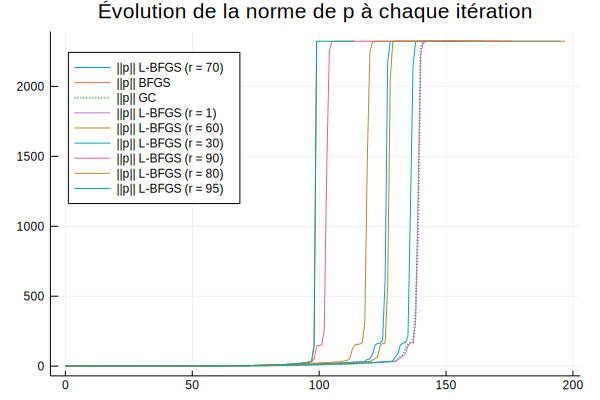

In [19]:
plot(0:iter, NormP, label = "||p|| L-BFGS (r = 70)", title = "Évolution de la norme de p à chaque itération", legend = :topleft)
plot!(0:iter₂, NormP₂, label = "||p|| BFGS")
plot!(0:(iterᵧ), NormPᵧ, label = "||p|| GC", lw = 2, line = :dot)
plot!(0:iter₁, NormP₁, label = "||p|| L-BFGS (r = 1)")
plot!(0:iter₃, NormP₃, label = "||p|| L-BFGS (r = 60)")
plot!(0:iter₄, NormP₄, label = "||p|| L-BFGS (r = 30)")
plot!(0:iter₅, NormP₅, label = "||p|| L-BFGS (r = 90)")
plot!(0:iter₆, NormP₆, label = "||p|| L-BFGS (r = 80)")
plot!(0:iter₇, NormP₇, label = "||p|| L-BFGS (r = 95)")

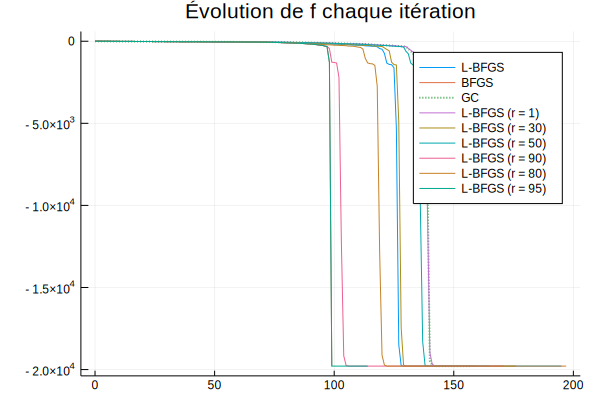

In [20]:
plot(0:iter, F, label = "L-BFGS", title = "Évolution de f chaque itération")
plot!(0:iter₂, F₂, label = "BFGS")
plot!(0:(iterᵧ), Fᵧ, label = "GC", lw = 2, line = :dot)
plot!(0:iter₁, F₁, label = "L-BFGS (r = 1)")
plot!(0:iter₃, F₃, label = "L-BFGS (r = 30)")
plot!(0:iter₄, F₄, label = "L-BFGS (r = 50)")
plot!(0:iter₅, F₅, label = "L-BFGS (r = 90)")
plot!(0:iter₆, F₆, label = "L-BFGS (r = 80)")
plot!(0:iter₇, F₇, label = "L-BFGS (r = 95)")

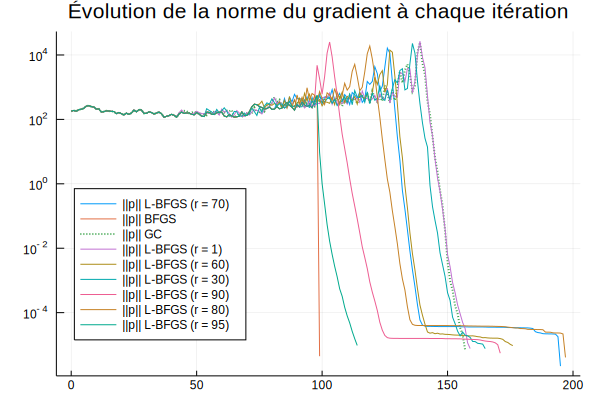

In [21]:
plot(0:(iter), G, label = "||p|| L-BFGS (r = 70)", title = "Évolution de la norme du gradient à chaque itération", legend = :bottomleft, yaxis = :log)
plot!(0:(iter₂), G₂, label = "||p|| BFGS")
plot!(0:(iterᵧ), Gᵧ, label = "||p|| GC", lw = 2, line = :dot)
plot!(0:(iter₁), G₁, label = "||p|| L-BFGS (r = 1)")
plot!(0:(iter₃), G₃, label = "||p|| L-BFGS (r = 60)")
plot!(0:(iter₄), G₄, label = "||p|| L-BFGS (r = 30)")
plot!(0:(iter₅), G₅, label = "||p|| L-BFGS (r = 90)")
plot!(0:(iter₆), G₆, label = "||p|| L-BFGS (r = 80)")
plot!(0:(iter₇), G₇, label = "||p|| L-BFGS (r = 95)")